In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Face_mask

[Errno 2] No such file or directory: '/content/drive/My Drive/Face_mask'
/content


In [ ]:
ls

drive/  sample_data/


#Data Preprocessing

In [ ]:
import cv2,os
data_path='/content/drive/My Drive/Face_mask/mask_datasets/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

FileNotFoundError: ignored

In [ ]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

#Recale and assign  catagorical lables

In [ ]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [ ]:
new_target.shape

(1376, 2)

In [ ]:
np.save('data.npy',data)
np.save('target.npy',new_target)

#CNN Model

In [ ]:
import numpy as np
data=np.load('data.npy')
new_target=np.load('target.npy')

In [ ]:
data.shape

(1376, 100, 100, 1)

In [ ]:
data.shape[1:]

(100, 100, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 200)       2000      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 52900)            

#Splittiong data into traning and testing

In [ ]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [ ]:
train_data.shape

(1238, 100, 100, 1)

In [ ]:
train_target.shape

(1238, 2)

In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/100
990/990 [==============================] - 10s 10ms/step - loss: 0.7309 - accuracy: 0.5566 - val_loss: 0.6362 - val_accuracy: 0.5887
Epoch 2/100
990/990 [==============================] - 3s 3ms/step - loss: 0.5655 - accuracy: 0.7040 - val_loss: 0.4499 - val_accuracy: 0.8185
Epoch 3/100
990/990 [==============================] - 3s 3ms/step - loss: 0.4219 - accuracy: 0.8081 - val_loss: 0.3629 - val_accuracy: 0.8710
Epoch 4/100
990/990 [==============================] - 3s 3ms/step - loss: 0.2727 - accuracy: 0.8990 - val_loss: 0.3221 - val_accuracy: 0.8750
Epoch 5/100
990/990 [==============================] - 3s 3ms/step - loss: 0.1745 - accuracy: 0.9283 - val_loss: 0.2447 - val_accuracy: 0.8952
Epoch 6/100
990/990 [==============================] - 3s 3ms/step - loss: 0.1337 - accuracy: 0.9525 - val_loss: 0.2247 - val_accuracy: 0.9234
Epoch 7/100
990/990 [==============================] - 3s 3ms/step - loss: 0.1214 - accuracy: 

In [ ]:
from matplotlib import pyplot as plt

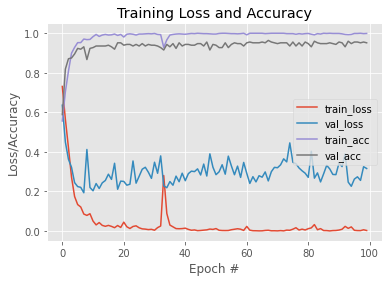

In [ ]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

#Detecting Faces with and without masks

In [ ]:
from keras.models import load_model
import cv2
import numpy as np

In [ ]:
model = load_model('/content/drive/My Drive/Face_mask/model-028.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

#Resnet

In [ ]:

import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

Using TensorFlow backend.


In [ ]:

#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/My Drive/Client/Face_mask/mask_datasets/with_mask',224))
malign_train = np.array(Dataset_loader('/content/drive/My Drive/Client/Face_mask/mask_datasets/without_mask',224))


100%|██████████| 686/686 [05:59<00:00,  1.91it/s]


In [ ]:

# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))


# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)


# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]


# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

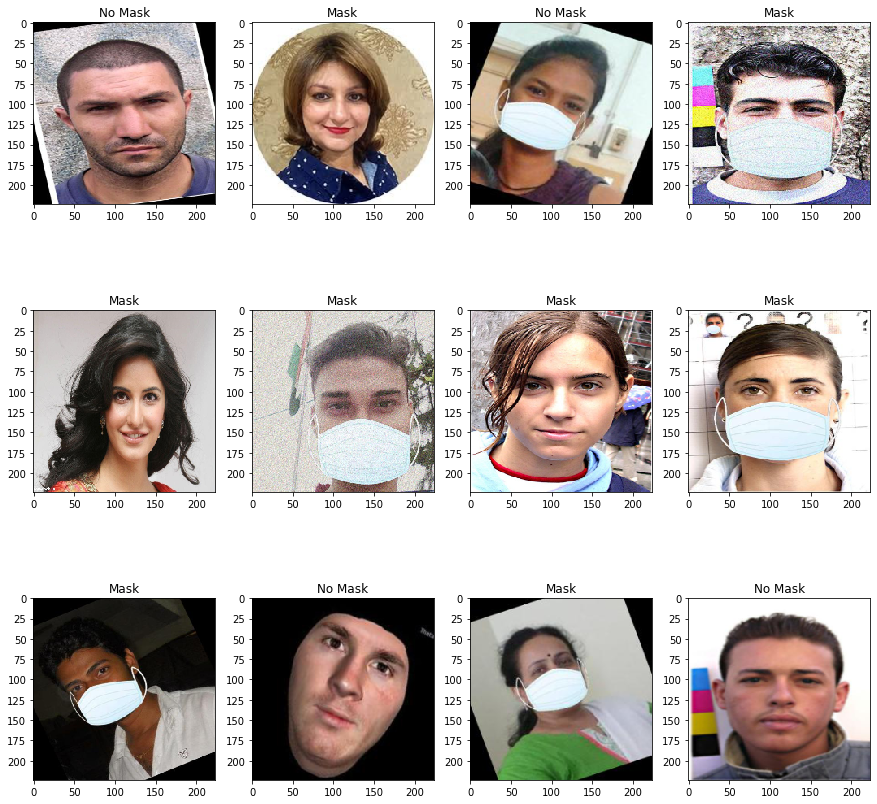

In [ ]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Mask')
    else:
        ax.title.set_text('No Mask')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(resnet ,lr = 1e-4)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
# Checkpoint
filepath="mask_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
69/68 [==============================] - 17s 252ms/step - loss: 0.1452 - accuracy: 0.9473 - val_loss: 0.0105 - val_accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to mask_weights.best.hdf5
Epoch 2/50
69/68 [==============================] - 16s 237ms/step - loss: 0.1029 - accuracy: 0.9636 - val_loss: 0.0427 - val_accuracy: 0.9891

Epoch 00002: val_accuracy did not improve from 1.00000
Epoch 3/50
69/68 [==============================] - 17s 241ms/step - loss: 0.1455 - accuracy: 0.9527 - val_loss: 0.0390 - val_accuracy: 0.9855

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/50
69/68 [==============================] - 16s 239ms/step - loss: 0.1336 - accuracy: 0.9582 - val_loss: 0.0056 - val_accuracy: 0.9964

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/50
69/68 [==============================] - 17s 243ms/step - loss: 0.0781 - accuracy: 0.9700 - val_loss: 0.0107 - val_accuracy: 0.9964

Epoch 00005: val_ac

In [ ]:
cd /content/drive/My Drive/Client/Face_mask

/content/drive/My Drive/Client/Face_mask


In [ ]:
model.save('mask_model_resnet.h5')

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

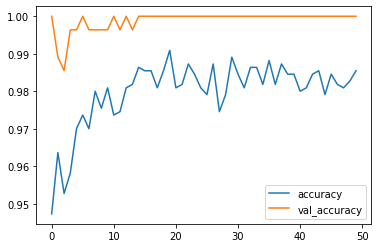

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

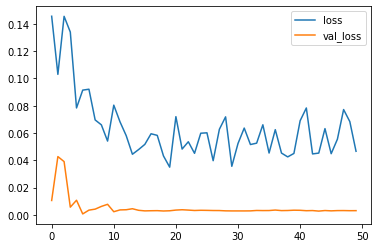

In [ ]:

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print(">> IMAGE CLASSIFICATION MODEL CREATION")

print()

print(">> STEP#1 IMAGE PRE-PROCESSING")
# train_image_generator = ImageDataGenerator(rescale=1.0/255)
# test_image_generator = ImageDataGenerator(rescale=1.0/255)

# training_images = train_image_generator.flow_from_directory(
#                                         'covid19dataset/train',
#                                         target_size=(64, 64),
#                                         batch_size=8,
#                                         class_mode='binary')

# testing_images = test_image_generator.flow_from_directory(
#                                         'covid19dataset/test',
#                                         target_size=(64, 64),
#                                         batch_size=8,
#                                         class_mode='binary')

train_dir='/content/drive/My Drive/Client/Face_mask/mask_datasets'
BATCH_SIZE=8


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.2 )
  
training_images = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(64, 64),
    subset="training", 
    shuffle=True, 
    seed=42,
    class_mode="binary",
    batch_size=BATCH_SIZE)


testing_images = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    target_size=(64, 64),
    seed=42,
    class_mode="binary",
    subset="validation",
    batch_size=BATCH_SIZE)


>> IMAGE CLASSIFICATION MODEL CREATION

>> STEP#1 IMAGE PRE-PROCESSING
Found 1101 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


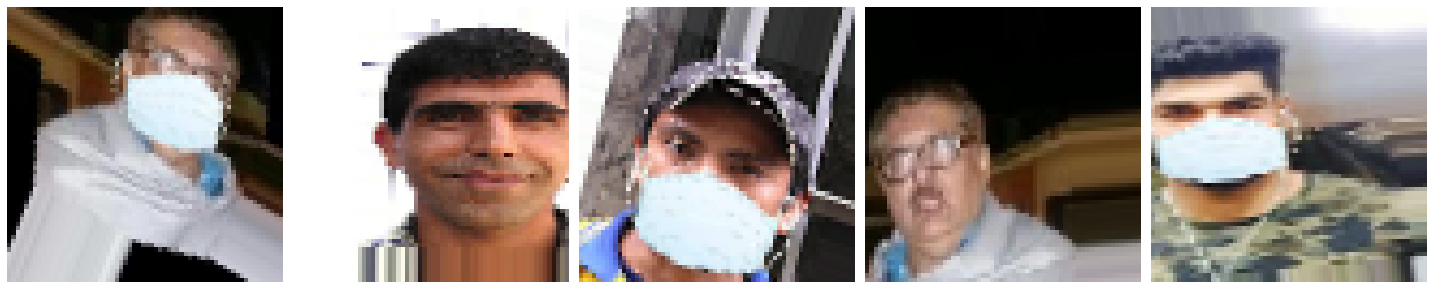

In [ ]:
def plotImages(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(training_images)
plotImages(sample_training_images[:5])

In [ ]:



print(">> STEP#2 CREATE CNN MODEL")
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Further Adding the NeuralNet in ConvNet Model
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(">> STEP#3 TRAIN THE MODEL")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# use fit_generator instead of fit  -> if we have used ImageDataGenerator for our Image Data Set Creation
model.summary()


>> STEP#2 CREATE CNN MODEL
>> STEP#3 TRAIN THE MODEL
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               802944    
_________________________________________________________________
d

In [ ]:
history = model.fit_generator(training_images, epochs=5, validation_data=testing_images)

Epoch 1/5
138/138 [==============================] - 701s 5s/step - loss: 0.4794 - accuracy: 0.7729 - val_loss: 0.3073 - val_accuracy: 0.8873
Epoch 2/5
138/138 [==============================] - 9s 68ms/step - loss: 0.3225 - accuracy: 0.8819 - val_loss: 0.2426 - val_accuracy: 0.9018
Epoch 3/5
138/138 [==============================] - 10s 69ms/step - loss: 0.2961 - accuracy: 0.8847 - val_loss: 0.2941 - val_accuracy: 0.8982
Epoch 4/5
138/138 [==============================] - 9s 69ms/step - loss: 0.2193 - accuracy: 0.9210 - val_loss: 0.2277 - val_accuracy: 0.8982
Epoch 5/5
138/138 [==============================] - 9s 68ms/step - loss: 0.1961 - accuracy: 0.9319 - val_loss: 0.1376 - val_accuracy: 0.9455


>> STEP#4 VISUALIZING ACCURACY AND LOSS


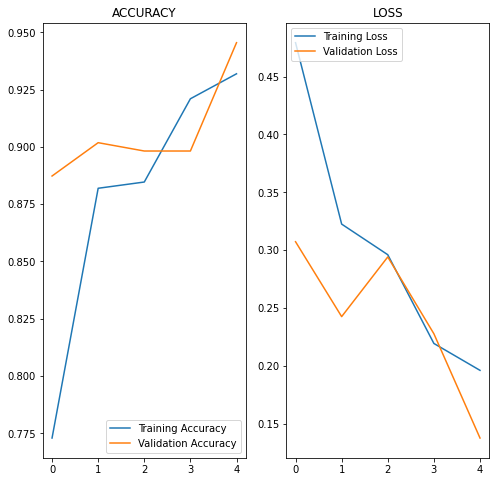

In [ ]:
print(">> STEP#4 VISUALIZING ACCURACY AND LOSS")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ACCURACY')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('LOSS')

plt.show()

In [ ]:
cd /content/drive/My Drive/Client

/content/drive/My Drive/Client


In [ ]:
model.save('simple_mode.h5')